### Mofified the initial code to include SpecAugment

In [1]:
!pip install --upgrade jupyterlab
!pip install --upgrade jupyter
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 9.2 MB 6.8 MB/s eta 0:00:01
     |████████████████████████████████| 377 kB 128.8 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 113.6 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 87.6 MB/s eta 0:00:01
     |████████████████████████████████| 427 kB 108.6 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 83.5 MB/s  eta 0:00:01
     |████████████████████████████████| 57 kB 105.0 MB/s eta 0:00:01
     |████████████████████████████████| 84 kB 120.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 113.6 MB/s eta 0:00:01
     |████████████████████████████████| 256 kB 123.5 MB/s eta 0:00:01
     |████████████████████████████████| 105 kB 150.5 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 91.0 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 77.4 MB/s eta 0:00:01
     |███████████████████████

In [2]:

import os
import pandas as pd
import sys
#sys.path.append(0, os.path.abspath('ComParE2022_VecNet/src'))
sys.path.append('../../src')

import config 
#from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
# import IPython.display as ipd

# humbug lib imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import time

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as AT
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.loss import BinaryCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob
## nnAudio
from nnAudio import features , Spectrogram
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import argparse
import torchvision.models.quantization as models


/opt/conda/lib/python3.8/site-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


In [3]:
model = models.resnet18(pretrained=True, progress=True, quantize=False)
num_ftrs = model.fc.in_features
model.train()
model.fuse_model()


/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 85.7MB/s]


In [4]:
def quant_prep(model_ft):
    model_ft[0].qconfig = torch.quantization.default_qat_qconfig  # Use default QAT configuration
# Step 3
    model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)
    for param in model_ft.parameters():
        param.requires_grad = True
    return(model_ft)
    

In [5]:
from torch import nn

def create_combined_model(model_fe):
    # Step 1. Isolate the feature extractor.
    model_fe_features = nn.Sequential(
    model_fe.quant,  # Quantize the input
    model_fe.conv1,
    model_fe.bn1,
    model_fe.relu,
    model_fe.maxpool,
    model_fe.layer1,
    model_fe.layer2,
    model_fe.layer3,
    model_fe.layer4,
    model_fe.avgpool,
    model_fe.dequant,  # Dequantize the output
  )

    # Step 2. Create a new "head"
    new_head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2),
   )

  # Step 3. Combine, and don't forget the quant stubs.
    new_model = nn.Sequential(
    model_fe_features,
    nn.Flatten(1),
    new_head,)
    
    model_ft  = quant_prep(new_model)
    
    return model_ft

In [6]:
model_ft = create_combined_model(model)



/opt/conda/lib/python3.8/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [7]:
# x = torch.rand(3,224,224)
# y_t = model_ft(x)
# print(y_t)
# torch.argmax(y_t, axis = 1)

In [8]:
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    #This is same as defined in config -min_duration = win_size * frame_duration
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    stride = step_frac*min_length
#     print("min_length = " +str(min_length))
#     print("step_frac = " +str(step_frac))
#     print("stride = " +str(stride))
    for _,row in df.iterrows():
        #processed_data keeps track of the tensor_values processed thus far
        if row['length'] > min_length:
            processed_data = 0
            #total_data is the total tensor present in the audio
            total_data = config.rate*row['length']
            label_ind = row['sound_type']
            if label_ind == 'mosquito':
                label_ind =1
            else:
                label_ind = 0
            #print("********")
            count = 0
            #print("count = " +str(count))
            #print("id = " + str(row['id']) + " duration = " +str(row['length']) + "total x vals = " + str(total_data))
            inner_loop_flag = False
            #print("going into the inner loop to offset....")
            while(processed_data < total_data):
                #print("inside inner loop.....")
                start = count*stride*config.rate
                #now find out the row_len
                if total_data - (start + min_length*config.rate) >= 0:
                    #print("full chunk ")
                    row_len = min_length
                    end = start + row_len*config.rate
                    audio_offsets.append({'id':row['id'], 'offset':count, 'length': row_len,'specie_ind': label_ind,'start':start,'end':end})
                    #print("count = " +str(count) + "offset = " +str(count) + "start = " +str(start) + "end = " +str(end))
                    #print("for count.... = " + str(count) + "processed data = " +str(processed_data))
                    count+=1
                    processed_data = (count*stride)*config.rate
                    
                else:
                    inner_loop_flag = True
                    break
                    
                                                       
            #for processing residual data
            if(inner_loop_flag):
                #print("processing residual ....processed " +str(processed_data) + " of " + str(total_data))
                start = count*stride*config.rate
                resid_durn = round((total_data - processed_data)/config.rate,2)
                end = total_data
                #print("for..." + str(row['id']) + " adding the residual data in the data frame with duration = " + str(resid_durn))
                audio_offsets.append({'id':row['id'], 'offset':count, 'length':resid_durn ,'specie_ind': label_ind,'start':start,'end':end})
            
        elif short_audio:
            label_ind = row['sound_type']
            if label_ind == 'mosquito':
                label_ind =1
            else:
                label_ind = 0
            start = 0
            end = row['length']*config.rate
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': label_ind,'start':0 , 'end':end})
    return pd.DataFrame(audio_offsets)

In [9]:
def prepare_df(csv_loc = config.data_df  ):
    """This function reads a csv and creates a dataframe for further processing."""
    df = pd.read_csv(csv_loc)
    idx_test_A = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'field')
    idx_test_B = np.logical_and(df['country'] == 'UK', df['location_type'] == 'culture')
    idx_train = np.logical_not(np.logical_or(idx_test_A, idx_test_B))
    #df_test_A = df[idx_test_A]
    #df_test_B = df[idx_test_B]
    #df = df.loc[df['Grade'].notnull()]
    
    return df


In [10]:
def plot_df(df):
    fig, ax = plt.subplots(figsize=(8, 6))
    import seaborn as sns
    sns.countplot(x = 'species', data = df , ax = ax , hue = 'gender',palette='dark')
    #ax.bar_label(ax.containers[0])
    #ax.bar_label(ax.containers[-1], fmt='Count:\n%.2f', label_type='center')
    plt.xticks(rotation=90 )
    plt.title("Distribution of Species ")
    plt.rc('xtick', labelsize=12)
    plt.rc('xtick', labelsize=12)
    plt.rc('axes', labelsize=15)
    plt.rc('figure', titlesize=15)
    plt.show

In [11]:
def train_test_split(df_all):
    np.random.seed(42)
    msk_test = np.random.rand(len(df_all)) < 0.2
    df_test = df_all[msk_test]
    df_train_temp  = df_all[~msk_test]
    msk_train = np.random.rand(len(df_train_temp)) < 0.2
    df_val = df_train_temp[msk_train]
    df_train  = df_train_temp[~msk_train]
    return df_train ,df_val ,df_test


In [12]:
def validate_split(df1 , df2):
    df_temp = pd.merge(df1,df2, on = 'id', how = 'inner')
    #print(df_temp)
    common_elem = len(df_temp)
    #print("common_elem = ",common_elem)
    con = (common_elem == 0)
    #print("condition = ",con)
    assert (con), "Split has issues"
    print("split is a success")

In [13]:
def get_specie_distri(df , classes , type_df = None):
    """This function takes a dataframe and provides a count of each specie class"""
    for i in range(len(classes)):
        print("DF type = " + str(type_df))
        df_temp = df[df['specie_ind'] == i]
        print("i = " +str(i))
        print(len(df_temp))

In [14]:
def get_class_weights(df):
    np.array(df_train_offset.specie_ind)
    from sklearn.utils import class_weight
    class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(df.specie_ind)),y=np.array(np.array(df.specie_ind)))
    print(type(class_weights))
    print(class_weights.shape)
    return class_weights

In [15]:
def pad_mean(x_temp,rate = config.rate, min_length = config.min_duration ):
    if DEBUG:
        print("inside padding mean...")
    x_mean = torch.mean(x_temp)
    #x_mean.cuda()
    
    if DEBUG:
        print("X_mean = " + str(x_mean))
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    if DEBUG:
        print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    if DEBUG:
        print("left_pad shape = " + str(left_pad.shape))
    left_pad_mean_add = left_pad + x_mean
    if DEBUG:
        print("left_pad_mean shape = " + str(left_pad_mean_add))
        print("sum of left pad mean add = " + str(torch.sum(left_pad_mean_add)))
    
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    if DEBUG:
        print("right_pad shape = " + str(right_pad.shape))
    right_pad_mean_add = right_pad + x_mean
    if DEBUG:
        print("right_pad_mean shape = " + str(right_pad_mean_add))
        print("sum of right pad mean add = "  + str(torch.sum(right_pad_mean_add)))
    
    
    
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    f = f.unsqueeze(dim = 0)
    #print("returning a tensor of shape = " + str(f.shape))
    return(f)

In [16]:
def plot_confusion_matrix(y_hat,y_true,classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_hat, y_true ,labels= range(len(classes)))
    import seaborn as sns
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)
    plt.show()

In [17]:
class Normalize_batch(nn.Module):
    def __init__(self):
        super(Normalize_batch, self).__init__()
        
    def forward(self, x):
        batch_mean = torch.mean(x, dim=0, keepdim=True)
        batch_std = torch.std(x, dim=0, keepdim=True)
        epsilon = 1e-8
        batch_std = torch.sqrt(batch_std ** 2 + epsilon)
        batch_normalized = (x - batch_mean) / batch_std
        return batch_normalized

In [18]:
# class MyModel(nn.Module):
#     def __init__(self,model = model,image_size = 224):
#         super().__init__()
#         # num_classes=0 removes the pretrained head
#         self.backbone = create_combined_model(model)
#         #####  This section is model specific
#         #### It freezes some fo the layers by name
#         #### you'll have to inspect the model to see the names
#                 #### end layer freezing
#         #self.out = nn.Linear(self.backbone.num_features, 1)
#         self.sizer = VT.Resize((image_size,image_size),antialias = True)
#         self.spec_layer = features.STFT(n_fft=int(config.NFFT), freq_bins=None, hop_length=int(config.n_hop),
#                               window='hann', freq_scale='linear', center=True, pad_mode='reflect',
#                            sr=config.rate, output_format="Magnitude", trainable=True,verbose = False).to('cuda')
#         self.batch_norm = nn.BatchNorm2d(num_features= 1)
#         #self.augment_layer = augment_audio(trainable = True, sample_rate = config.rate)
#         self.quant = torch.ao.quantization.QuantStub()
#         self.dequant = torch.ao.quantization.DeQuantStub()
        
        
#     def forward(self, x,train = True):
#         # first compute spectrogram
#         #x = self.quant(x)
#         spec_gram = self.spec_layer(x)
#         #print("post spec gram shape = ",spec_gram.shape)
#         spec_gram = self.batch_norm(spec_gram.unsqueeze(dim = 1))
#         #print("post norm shape = ",spec_gram.shape)
#         spec_gram_nan_check = torch.isnan(spec_gram).any().item()
#         assert not (spec_gram_nan_check) ,"Tensor contains NaN values after spec gram creation."
        
#         with torch.no_grad():
#             if train == True:
#                 #generate a random number and if condition is met apply aug
#                 ta_transformations_rndm_choice = VT.RandomChoice([AT.FrequencyMasking(freq_mask_param=100),AT.TimeMasking(time_mask_param=50)], p=[.4, .4])
#                 ta_transformations_rndm_apply = VT.RandomApply([AT.FrequencyMasking(freq_mask_param=50),AT.TimeMasking(time_mask_param=25)],p = .15)
#                 spec_gram = ta_transformations_rndm_choice(spec_gram)
#                 spec_gram = ta_transformations_rndm_apply(spec_gram)
#                 spec_gram_nan_check = torch.isnan(spec_gram).any().item()
#                 assert not (spec_gram_nan_check) ,"Tensor contains NaN values after augmentations  "
                
                
            
        
#         x = self.sizer(spec_gram.squeeze(dim = 1))
#         #print("post sizer shape = ",x.shape)
#         x = x.unsqueeze(dim = 1)
#         #print("post unsqueeze shape = ",x.shape)
        
#         # then repeat channels
#         del spec_gram,spec_gram_nan_check
#         if DEBUG:
#             print("Final shape that goes to backbone = " + str(x.shape))
                
#         x = x.expand(-1, 3, -1, -1)
#         #print("post expansion x device = ",x.device)
#         x = self.backbone(x)
#         backbone_op_nan_check = torch.isnan(x).any().item()
#         assert not (backbone_op_nan_check) ,"Tensor contains NaN values in the backbone OP "
#         #print("x shape after backbone  = " + str(x.shape))
#         #print("output of model = " +str(x))
#         #pred = nn.Softmax(x)
#         #x = self.dequant(x)
#         pred = x
#         #print(np.argmax(pred.detach().cpu().numpy()))
#         #print(pred)
#         output = {"prediction": pred }
#         #print(output)
#         del x , backbone_op_nan_check
#         return output


In [19]:
def get_specgram_apply_aug(x , train = True , image_size = 224):
    
    sizer = VT.Resize((image_size,image_size),antialias = True)
    spec_layer = features.STFT(n_fft=int(config.NFFT), freq_bins=None, hop_length=int(config.n_hop),
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                           sr=config.rate, output_format="Magnitude", trainable=False,verbose = False).to('cuda')
    batch_norm = nn.BatchNorm2d(num_features= 1).to('cuda')
    x.to('cuda')
    #print("x device before spec gram = " , x.device)
    spec_gram = spec_layer(x)
    #print("post spec gram generation device  = " , spec_gram.device)
    spec_gram.to('cuda')
    spec_gram = spec_gram.unsqueeze(dim = 1).to('cuda')
    #print("post unsqueeze device  = " , spec_gram.device)
    spec_gram = batch_norm(spec_gram)
    #print("post norm device  = " , spec_gram.device)
    
    if train == True:
        #generate a random number and if condition is met apply aug
        ta_transformations_rndm_choice = VT.RandomChoice([AT.FrequencyMasking(freq_mask_param=100),AT.TimeMasking(time_mask_param=50)], p=[.4, .4])
        ta_transformations_rndm_apply = VT.RandomApply([AT.FrequencyMasking(freq_mask_param=50),AT.TimeMasking(time_mask_param=25)],p = .15)
        spec_gram = ta_transformations_rndm_choice(spec_gram)
        spec_gram = ta_transformations_rndm_apply(spec_gram)
        spec_gram_nan_check = torch.isnan(spec_gram).any().item()
        assert not (spec_gram_nan_check) ,"Tensor contains NaN values after augmentations  "
    
    spec_gram = sizer(spec_gram.squeeze(dim = 1))
    #converting to 3 channels as required by resnet.
    spec_gram = spec_gram.unsqueeze(dim = 1)
    spec_gram = spec_gram.expand(-1, 3, -1, -1)
    #print("shape of spec gram being returned = ", spec_gram.shape)
    
    return spec_gram
    
    
    
    

In [20]:
# x = torch.rand(64,15360, device = 'cuda')
# t = get_specgram_apply_aug(x)

In [21]:
def test_model(model, loader, criterion,  device=None , call = "val"):
    softmax = nn.Softmax()
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            if DEBUG:
                print("y = " + str(y))
            spec = get_specgram_apply_aug(x, train = False)
            y_pred = model(spec)
            #y_pred_smax = softmax(y_pred)
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            #preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        test_loss = test_loss/len(test_loader)
        test_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
    
    
    return test_loss, test_f1 , all_y,all_y_pred
## Train_model ####
#train_loader, val_loader, test_loader,model,classes,df_train_offset ,num_epochs = num_epochs 


In [22]:
def train_model(train_loader, val_loader,test_loader, model ,class_weights,num_epochs ):
    # Creates a GradScaler once at the beginning of training.
    torch.manual_seed(0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)
    weights_adj = torch.tensor(class_weights).type(torch.float).to(device)
    criterion = BinaryCrossEntropy(weight=weights_adj)
    lr = .000015
    base_optimiser = timm.optim.AdamP(model.parameters(), lr= lr)
    look_optimiser = timm.optim.Lookahead(base_optimiser)
    cooldown_epoch = 50
    
    #optimiser = timm.optim.AdamW(model.parameters(), lr=config_pytorch.lr)
    #timm.optim.Lookahead(optimiser, alpha=0.5, k=6)
    scheduler = timm.scheduler.CosineLRScheduler(base_optimiser, t_initial= num_epochs,lr_min= lr/100,warmup_t = 5,warmup_lr_init= lr/10,noise_std=.075)
    
    
    #optimiser = timm.optim.RAdam(model.parameters(), lr=config_pytorch.lr/10)
    num_epochs = num_epochs
    all_train_loss = []
    all_train_f1 = []
    all_val_loss = []
    all_val_f1 = []
    best_val_loss = np.inf
    best_val_f1 = -np.inf
    best_train_f1 = -np.inf
    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    sigmoid = nn.Sigmoid()
    softmax = nn.Softmax()
    all_train_f1 = []
    all_val_f1 = []
    accumulation_steps = 4
    lr_log = []
    for e in range(num_epochs + cooldown_epoch):
        start_time = time.time()
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        #tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(train_loader):
            if DEBUG:
                print("inside train loop.. batch_ind = " +str(batch_i))
            if batch_i % 20 == 0:
                bat_time = time.time()
                durn = (bat_time - start_time)/60
                print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
            x = inputs[0].to(device).float()
            #create a transformation here
            # create a spectrogram and call for the randomization
            spec = get_specgram_apply_aug(x, train = True)
            if DEBUG:
                print("inside train loop.. x device = " +str(x.device))
                
            
            y = inputs[1].type(torch.LongTensor).to(device)
                                             
            with autocast():
                spec.to(device)
                y_pred = model(spec)
                #y_pred_smax = softmax(y_pred)
                preds = torch.argmax(y_pred, axis = 1)
                loss = criterion(y_pred, y)
                            
            if DEBUG:
                    print("y_pred  = " +str(y_pred))
                    print("preds = " +str(preds))
                   
            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            y_pred_cpu = y_pred.cpu().detach()
            #preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("batch_ind = " +str(batch_i))
                print("y_pred_cpu = " + str(y_pred_cpu))
                
            loss.backward()
            all_y_pred.append(preds.cpu().detach())
            base_optimiser.step()
            base_optimiser.zero_grad()
            #scheduler.step(e)
                
            
            torch.nn.utils.clip_grad_norm_(model.parameters(),error_if_nonfinite=False ,max_norm = 1.0 )
            base_optimiser.step()
            del x
            del y
            del y_pred,preds
        
        #lr_log.append(lr)
        look_optimiser.sync_lookahead()
        all_train_loss.append(train_loss/len(train_loader))
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        train_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
        all_train_f1.append(train_f1)
        if DEBUG:
            print("train acc = " +str(train_acc))
        all_train_f1.append(train_f1)
        val_loss, val_f1 , _,_ = test_model(model, val_loader, criterion = criterion, device=device, call = "val")
        all_val_f1.append(val_f1)
        all_val_loss.append(val_loss)
        if DEBUG:
            print("val F1 = " + str(val_f1))
        all_val_loss.append(val_loss)
        all_val_f1.append(val_f1)
        
        acc_metric = val_f1
        best_acc_metric = best_val_f1
        if acc_metric > best_acc_metric:  
            overrun_counter = -1
            checkpoint_name = f'model_med{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
            torch.save(model.state_dict(), os.path.join(config.model_dir,  checkpoint_name))
            sys.stdout.flush()
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
            print('Saving model to:', os.path.join(config.model_dir,  checkpoint_name)) 
            print("Now printing classification rport... ")
            print("********************************")
            current_lr = base_optimiser.param_groups[0]['lr']
            print("Current LR = " + '{0:.8f}'.format(current_lr))
            from sklearn.metrics import classification_report
            _, _ , all_y_test,all_y_pred_test = test_model(model, val_loader, criterion = criterion, device=device, call = "test")
            # at times output is not getting printed. Could be due to multi threading and hence adding sleep
            time.sleep(2)
            sys.stdout.flush()
            print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= ["0","1"]))
            print("********************************")
            time.sleep(2)
            plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , ["0","1"])
            best_epoch = e
            best_val_f1 = val_f1
            best_val_loss = val_loss
            
        else:
            print("..Overrun....no improvement")
            overrun_counter += 1
            sys.stdout.flush()
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
        scheduler.step(e+1)
        if overrun_counter > 20:
            break
            
    
    return model, lr_log,all_train_f1,all_train_loss,all_val_loss,all_val_f1



#### Dataste class #####


In [23]:
class MozDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        temp_id = int(self.audio_df.loc[idx]['id'])
        file_path = os.path.join("..","data","audio")
        path_var = file_path +"/" +str(temp_id)+ str(".wav")
        entire_aud, inp_rate = torchaudio.load(path_var)
        #print("processsing file on " +str(path_var))
        if inp_rate != config.rate:
            #print(" Original sample rate = " +str(inp_rate)+ " resampling ...")
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=entire_aud.dtype)
            entire_aud = resampler(entire_aud)
            #print("processsing file on " +str(path_var) + "Post resample shape =  " + str(entire_aud.shape))
        
        aud_len = self.audio_df.loc[idx]['length']
        offset = int(self.audio_df.loc[idx]['offset'])
        #print("sliced val = " +str(int((offset+config.min_duration)*config.rate)))
        start_pos = int(round(self.audio_df.loc[idx]['start']))
        #print("start_pos = " +str(start_pos))
        end_pos =  int(round(self.audio_df.loc[idx]['end']))
        #print("end_pos = " +str(end_pos))
        x = entire_aud[:,start_pos:end_pos]
        #print("extracted x = " +str(x))
        #print("x shape = " +str(x.shape))
        if (aud_len < config.min_duration) or (x.shape[1] < 15360):
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            #print("padding on " +str(path_var))
            f_out = pad_mean(x)
            #print("returning from padding  SHape = " +str(f_out.shape))
        else:
            f_out = x[0]
            f_out = f_out.unsqueeze(0)
            #print("inside else, returned  SHape = " +str(f_out.shape))
            
        if DEBUG:
            print("idx = " + str(idx))
            #print("offset = " + str(offset))
            #print("shape of x post augmentation = " + str(x.shape))
            print("from get_item of train, returning  x of shape = " +str(f_out.shape))
        
        #x_val = x[:,start:end]
        #now that we have final x- let's create specgram and add augmentations.
                 
        return (f_out,self.audio_df.loc[idx]['specie_ind'] )

In [24]:
# def get_indices(num_values ,df ,classes = classes):
#     new_df = pd.DataFrame()
#     for ind in range(len(classes)):
#         #print("ind = ", ind)
#         op = df[df['specie_ind'] == ind]
#         #print("len op = ", len(op))
#         op_new = op.sample(n = 1)
#         #print("rand_ind = " , rand_ind)
#         #([df1, df2], axis=1)
#         new_df = pd.concat([op_new,new_df],axis = 0)
#         #print("elem = " , elem)
#         #new_list.append(elem)
#     if len(new_df) < num_values:
#         diff =  num_values - len(new_df)
#         #print("diff = ", diff)
#         remaining_elems= df.sample(n = diff)
#         #print("len of remaining elems = ", len(remaining_elems))
#         new_df = pd.concat([remaining_elems,new_df],axis = 0)
        
#     #print("new_df = ", new_df)    
#     new_df_1 = new_df.reset_index(drop = True)
#     return new_df_1

In [25]:
# def load_model(filepath, model=MyModel('convnext_xlarge_in22k')):
#     # Instantiate model to inspect
#     print("Filepath = " + str(filepath))
#     print("model = " +str(model))
#     device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
#     print(f'Training on {device}')
        
#     if torch.cuda.device_count() > 1:
#         print("Using data parallel")
#         model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
#     model = model.to(device)
#     # Load trained parameters from checkpoint (may need to download from S3 first)


#     if torch.cuda.is_available():
#         map_location=lambda storage, loc: storage.cuda()
#     else:
#         map_location='cpu'
        
#     checkpoint = model.load_state_dict(torch.load(filepath))

#     return model

In [26]:
batch_size = 2048
pin_memory = True
num_workers = 8
num_epochs = 200
short_audio=True
DEBUG = False

In [27]:
print("inside main.....")
print("The current working directory is ", os.getcwd())
csv_loc = os.path.join("..","data","metadata","neurips_2021_zenodo_0_0_1.csv")
df = prepare_df(csv_loc = csv_loc)
#plot_df(df)
df_train ,df_val ,df_test = train_test_split(df)
print("now validating the split post loading and keeping TZ data")
validate_split(df_train ,df_val)
validate_split(df_train ,df_test)
validate_split(df_test ,df_val)
df_train_offset = get_offsets_df(df_train, short_audio=True)
df_test_offset = get_offsets_df(df_test, short_audio=True)
df_val_offset = get_offsets_df(df_val, short_audio=True)
df_train_offset.reset_index(inplace = True , drop = True)
df_test_offset.reset_index(inplace = True , drop = True)
df_val_offset.reset_index(inplace = True , drop = True)
print("now validating the split post offset_creation")
validate_split(df_train_offset ,df_val_offset)
validate_split(df_train_offset ,df_test_offset)
validate_split(df_test_offset ,df_val_offset)

inside main.....
The current working directory is  /dli/task/notebooks
now validating the split post loading and keeping TZ data
split is a success
split is a success
split is a success
now validating the split post offset_creation
split is a success
split is a success
split is a success


In [28]:
class_weights = get_class_weights(df_train_offset)
print("inside main. class_weigths type = ", type(class_weights))
model = create_combined_model(model)
min_length = (config.win_size * config.n_hop) / config.rate

train_dataset = MozDataset(df_train_offset,  config.data_dir, min_length)
val_dataset = MozDataset(df_val_offset,  config.data_dir, min_length)
test_dataset = MozDataset(df_test_offset,  config.data_dir, min_length)

train_loader = torch.utils.data.DataLoader(train_dataset, num_workers=num_workers,batch_size = batch_size,shuffle = True, pin_memory=True )
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory, shuffle = True )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,num_workers= num_workers, pin_memory=pin_memory,shuffle = True)

<class 'numpy.ndarray'>
(2,)
inside main. class_weigths type =  <class 'numpy.ndarray'>


Training on cuda:0
epoch = 0batch = 0 of 55duraation = 0.9035072684288025
epoch = 0batch = 20 of 55duraation = 2.9172995686531067
epoch = 0batch = 40 of 55duraation = 5.495684051513672
Epoch: 0, Train Loss: 0.76672256, Train f1: 0.50272389, Val Loss: 0.04029807, Val f1: 0.52637483, overrun_counter -1
Saving model to: /dli/task/models/model_med0_2023_11_08_22_44_10.pth
Now printing classification rport... 
********************************
Current LR = 0.00000150
              precision    recall  f1-score   support

           0       0.89      0.14      0.24     13006
           1       0.56      0.99      0.72     14596

    accuracy                           0.59     27602
   macro avg       0.73      0.56      0.48     27602
weighted avg       0.72      0.59      0.49     27602

********************************


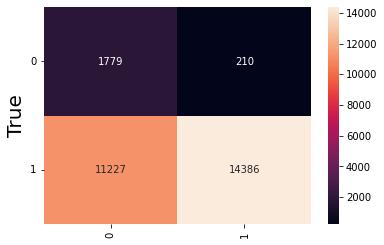

KeyboardInterrupt: 

In [29]:

#train_loader, val_loader,test_loader, model ,class_weights, classes = classes, num_epochs = args.num_epochs ,n_channels = 1
#train_loader, val_loader,test_loader, model, classes ,df,num_epochs = args.num_epochs ,n_channels = 1
tr_model, lr_log,all_train_f1,all_train_loss,all_val_loss,all_val_f1 = train_model(train_loader, val_loader, test_loader,model,class_weights ,num_epochs = num_epochs )

print("ALL DONE!!!!")
